# **SPAM vs. naiwny klasyfikator Bayesa**
Autor: Anna Dawid

## Wprowadzenie
Nigeryjski książę wciąż zarabia na użytkownikach elektronicznych skrzynek pocztowych ponad 700 tys. dolarów rocznie ([źródło](https://www.cnbc.com/2019/04/18/nigerian-prince-scams-still-rake-in-over-700000-dollars-a-year.html))! Jak to możliwe?

Pierwsza przyczyna jest natury psychologicznej. Ofiary są poddawane "perfekcyjnej burzy pokuszeń", jak ujął to psycholog w wywiadzie, do którego linka dałam Wam powyżej. Spammerzy łączą granie na ludzkiej chciwości, ale także na pragnieniu bycia bohaterem. W końcu kto nie chciałby zarobić na byciu wspaniałomyślnym i szczodrym? W tej kwestii możemy pracować wyłącznie nad sobą.

Możemy za to pracować nad filtrami antyspamowymi. Użyjemy techniki, która nazywa się "worek ze słowami" (bag of words) w połączeniu z naiwnym klasyfikatorem Bayesa. Choć to prosty klasyfikator, z powodzeniem jest używany współcześnie (np. [SpamAssassin](https://cwiki.apache.org/confluence/display/spamassassin/BayesInSpamAssassin)).

Notebook oparty na tutorialach:
*   https://towardsdatascience.com/spam-classifier-in-python-from-scratch-27a98ddd8e73
*   https://towardsdatascience.com/spam-filtering-using-naive-bayes-98a341224038


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Import danych treningowych
https://www.kaggle.com/uciml/sms-spam-collection-dataset

To dane przygotowane przez Almeida et al. na podstawie forum brytyjskiego, gdzie użytkownicy skarżą się na spamowe SMSy. Każdy wiersz składa się z kolumny opisującej czy wiadomość jest spamem, czy nie ('spam' czy 'ham'), a druga zawiera treść wiadomości.

In [2]:
df = pd.read_csv('./dane/spam.csv')
print(df)

        v1                                                 v2 Unnamed: 2  \
0      ham  Go until jurong point, crazy.. Available only ...        NaN   
1      ham                      Ok lar... Joking wif u oni...        NaN   
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3      ham  U dun say so early hor... U c already then say...        NaN   
4      ham  Nah I don't think he goes to usf, he lives aro...        NaN   
...    ...                                                ...        ...   
5567  spam  This is the 2nd time we have tried 2 contact u...        NaN   
5568   ham              Will �_ b going to esplanade fr home?        NaN   
5569   ham  Pity, * was in mood for that. So...any other s...        NaN   
5570   ham  The guy did some bitching but I acted like i'd...        NaN   
5571   ham                         Rofl. Its true to its name        NaN   

     Unnamed: 3 Unnamed: 4  
0           NaN        NaN  
1           NaN        NaN  


Dane zawierają zbyteczne kolumny. **Proszę**:
* usunać kolumny zawierająca wartości "NaN"
* zmienić nazwy kolumn "v1" i "v2" na "label", "text"

**Wskazówka**: proszę użyć metod ```DataFrame.dropna()``` oraz ```DataFrame.rename()```

In [3]:
#BEGIN_SOLUTION
df = df.dropna(axis=1)
df = df.rename(columns={'v1': 'label', 'v2': 'text'})
#END_SOLUTION
df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


**Proszę**: wypisać na ekran treść maila o indeksie 57

**Wskazówka**: Indeksy obiektu DataFreame uzyskujemy przez pole ```DataFrame.index```

In [4]:
#BEGIN_SOLUTION
index = 57
print(df[df.index==57])
#END_SOLUTION
pass

   label                                text
57   ham  Sorry, I'll call later in meeting.


## Analiza częstości występowania słów w obu klasach za pomocą biblioteki WordCloud

To biblioteka pozwalająca generować śliczne obrazki, na których wielkość słów odpowiada częstości jego występowania w danym zbiorze.

In [5]:
!pip3 install wordcloud
import wordcloud

Poniżej kod generujący obrazki dla spamu:

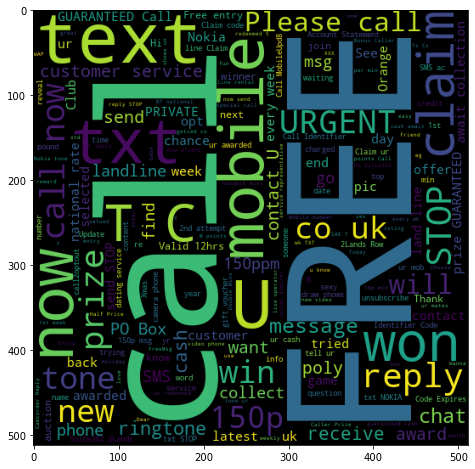

In [6]:
from wordcloud import WordCloud

spam_words = " ".join(list(df [df['label']=='spam']['text'] ))
spam_plot = WordCloud(width = 512, height = 512).generate(spam_words)

plt.figure(figsize=(10,8))
plt.imshow(spam_plot);

**Proszę**: Stwórz analogiczny obrazek dla klasy 'ham'

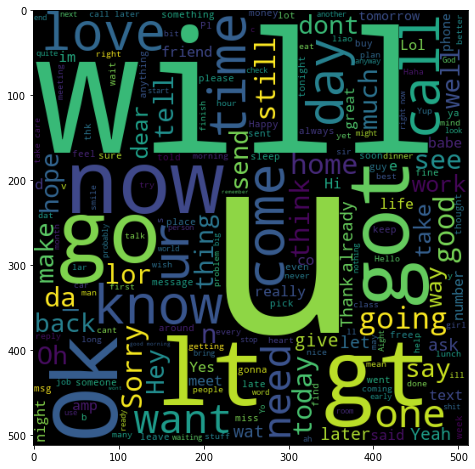

In [7]:
#BEGIN_SOLUTION
ham_words = " ".join(list(df [df['label']=='ham']['text'] ))
ham_plot = WordCloud(width = 512, height = 512).generate(ham_words)

plt.figure(figsize=(10,8))
plt.imshow(ham_plot);
#END_SOLUTION
pass

Dane w tej chwili są w postaci ciągów słów. Zamienimy je na postać numeryczną używająć algorymtu ```CountVectorizer```.
Na początek zróbmy to dla prostego tekstu by zrozumieć jak działa ten algorytm.

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
text = ["Ala ala ma kota.", "Kot? Kot ma wszy."]
vectorizer = CountVectorizer()
vectorizer.fit(text)
print("Vocabulary:", vectorizer.vocabulary_)
print("Lista słów:", vectorizer.get_feature_names_out())
text_transformed = vectorizer.transform(text)
print("Original text:",text)
print("Transformed text:",text_transformed)
print("Transformed text after decoding",vectorizer.inverse_transform(text_transformed))

Vocabulary: {'ala': 0, 'ma': 3, 'kota': 2, 'kot': 1, 'wszy': 4}
Lista słów: ['ala' 'kot' 'kota' 'ma' 'wszy']
Original text: ['Ala ala ma kota.', 'Kot? Kot ma wszy.']
Transformed text:   (0, 0)	2
  (0, 2)	1
  (0, 3)	1
  (1, 1)	2
  (1, 3)	1
  (1, 4)	1
Transformed text after decoding [array(['ala', 'kota', 'ma'], dtype='<U4'), array(['kot', 'ma', 'wszy'], dtype='<U4')]


**Proszę**:

* przeprowadzić procedurę treningu i transformacji dla danych z e-maili.
* W dokumentacji CountVectorizer znajdź informację o parametrach max_df i min_df. Następnie spróbuj zastosować te parametry. Wpływ ich działania możesz kontrolować poprzez metodę ```vectorizer.stop_words_```.
* wypisać na ekran postać oryginalną i po transformacji maila o indeksie **57**.

In [9]:
#BEGIN_SOLUTION
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vectorizer = CountVectorizer(max_df=0.1)
vectorizer.fit(df.text)
data = df.text
idx = 57
text = df[df.index==57]
text_transformed = vectorizer.transform(df.text)
print("Original text:",df[df.index==57])
print("Transformed text:",text_transformed[df.index==57])
print("Transformed text after decoding",vectorizer.inverse_transform(text_transformed[df.index==57]))
print("Terms that were ignored",vectorizer.stop_words_)
#END_SOLUTION
pass

Original text:    label                                text
57   ham  Sorry, I'll call later in meeting.
Transformed text:   (0, 1810)	1
  (0, 4500)	1
  (0, 4645)	1
  (0, 4935)	1
  (0, 7048)	1
Transformed text after decoding [array(['call', 'later', 'll', 'meeting', 'sorry'], dtype='<U34')]
Terms that were ignored {'is', 'the', 'you', 'it', 'to', 'and', 'me', 'for', 'in', 'my', 'your'}


## Trening klasyfikatora

**Proszę**:
* stworzyć kolumnę num_label w której 'spam' będzie oznaczony 1, a 'ham' 0
* podzielić dane na część treningową i testową w stosunku **7:3**
* wytrenować klasyfikator mail korzysjając z naiwnego algorytmu Bayesa opartego o rozkład wielomianowy: ```MultinomialNB```

In [10]:
from sklearn.model_selection import train_test_split
# stwórz nową kolumnę
#BEGIN_SOLUTION
df['num_label'] = df.label == 'spam'
#END_SOLUTION

# Podziel dane
#BEGIN_SOLUTION
X_train, X_test, Y_train, Y_test = train_test_split(text_transformed, df.num_label, test_size=0.3)
#END_SOLUTION

# zaimportuj odpowiednią bibliotekę
#BEGIN_SOLUTION
from sklearn.naive_bayes import MultinomialNB
#END_SOLUTION

# stwórz obiekt klasyfikatora
#BEGIN_SOLUTION
model = MultinomialNB()
#END_SOLUTION

# naucz klasyfikator na zbiorze uczącym
#BEGIN_SOLUTION
model.fit(X_train, Y_train);
#END_SOLUTION
pass

## Ocena jakości

**Proszę**: Spróbuj sam/sama ocenić jakość modelu. Wybierz metryki, które według Ciebie będą najlepiej sprawdzały czy nasz model jest dobrym filtrem spamowym.

0.9162671650390657


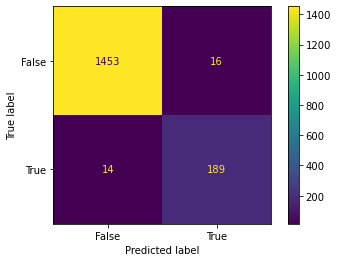

In [11]:
# Zaimportuj potrzebne funkcje z sklearn.metrics
#BEGIN_SOLUTION
from sklearn.metrics import matthews_corrcoef, ConfusionMatrixDisplay
#END_SOLUTION

def printScores(model, X, Y):
    #BEGIN_SOLUTION
    y_pred = model.predict(X)
    ConfusionMatrixDisplay.from_estimator(model, X, Y)
    mcc = matthews_corrcoef(Y, y_pred)
    print(mcc)
    #END_SOLUTION

printScores(model, X_test, Y_test)

## Analiza modelu

Sprawdźmy, czego właściwie maszyna się nauczyła. Analizując współczynniki modelu proszę wskazać słowa które są istotne dla klasyfikacji.

**Proszę**:
* obliczyć prawdopodobieństwa przypisane do kolejnych słów (```np.exp(model.feature_log_prob_)```)
* stworzyć listę o długości zawierającą indeksy posortowanych współczynników: ```np.argsort(...)```
* wypisać na ekran po N słów o największych wartościach współczynników dla każdej z klas malejąco.

**Wskazówka** by listę słów moć adresować listą indeksów, listę słów trzeba zamienić na macierz numpy.

In [12]:
N = 10

# Stwórz macierz numpy 'feature_names' ze słowami zapisanymi w module vectorizer:
#BEGIN_SOLUTION
feature_names = vectorizer.get_feature_names_out()
feature_names = np.array(feature_names)
#END_SOLUTION

# Stwórz macierz 'coeff' z prawdopodobieństwami odpowiadającymi słowom z macierzy 'feature_names':
#BEGIN_SOLUTION
coeff = np.exp(model.feature_log_prob_)
#END_SOLUTION

# Znajdź indeksy N najważniejszych słów dla każdej z klas
#BEGIN_SOLUTION
imp_spam = np.argsort(coeff[1])[-N:][::-1]
imp_ham = np.argsort(coeff[0])[-N:][::-1]
#END_SOLUTION

print("Słowa, które z największą pewnością wskazują maszynie, że wiadomość to spam:")
print(feature_names[imp_spam])

print("Słowa, które z największą pewnością wskazują maszynie, że wiadomość to nie spam:")
print(feature_names[imp_ham])

Słowa, które z największą pewnością wskazują maszynie, że wiadomość to spam:
['call' 'free' 'now' 'or' 'on' 'txt' 'ur' 'have' 'from' 'mobile']
Słowa, które z największą pewnością wskazują maszynie, że wiadomość to nie spam:
['that' 'of' 'so' 'have' 'but' 'can' 'not' 'are' 'at' 'do']


## Gdybyście byli spammerami... Co moglibyście zrobić, znając tę technikę antyspamową?

### Stosowanie znaków specjalnych zamiast liter

In [13]:
our_message = vectorizer.transform(['call for free'])
print(model.predict(our_message))

our_tricky_message = vectorizer.transform(['c@ll for free'])
print(model.predict(our_tricky_message))

[ True]
[False]


### Jakieś inne pomysły? :)

# Praca domowa

**Proszę**: Przeprowadź analogiczną analizę dla zbioru tytułów artykułów (https://www.kaggle.com/datasets/algord/fake-news?resource=download) posiadających informację o tym czy dany artykuł jest prawdziwy.

In [14]:
# Wczytaj dane
#BEGIN_SOLUTION
df = pd.read_csv('./dane/FakeNewsNet.csv')[['title', 'real']]
df = df.rename(columns={'real': 'label', 'title': 'text'})
#END_SOLUTION
df.head()

,text,label
0,Kandi Burruss Explodes Over Rape Accusation on...,1
1,People's Choice Awards 2018: The best red carp...,1
2,Sophia Bush Sends Sweet Birthday Message to 'O...,1
3,Colombian singer Maluma sparks rumours of inap...,1
4,Gossip Girl 10 Years Later: How Upper East Sid...,1


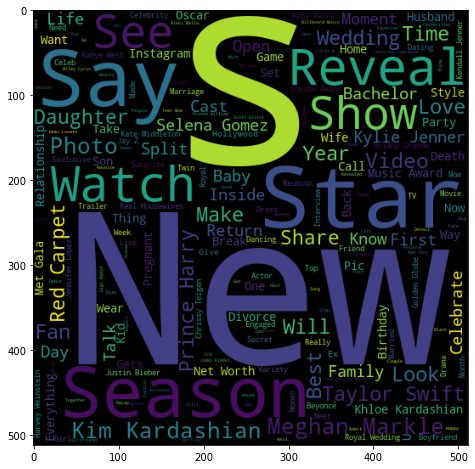

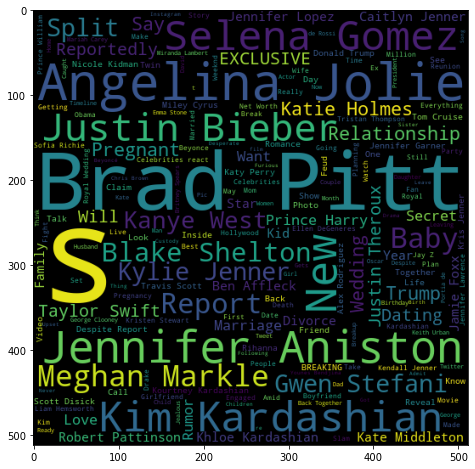

In [15]:
# Narysuj WordCloud dla obu przypadków
#BEGIN_SOLUTION
real_news_words = " ".join(list(df [df['label']==1]['text'] ))
real_news_plot = WordCloud(width = 512, height = 512).generate(real_news_words)

plt.figure(figsize=(10,8))
plt.imshow(real_news_plot);

fake_news_words = " ".join(list(df [df['label']==0]['text'] ))
fake_news_plot = WordCloud(width = 512, height = 512).generate(fake_news_words)

plt.figure(figsize=(10,8))
plt.imshow(fake_news_plot);
#END_SOLUTION
pass

In [16]:
# Wytrenuj CountVectorizer i zrób transformację. Dopasuj parametry max_df i min_df.
#BEGIN_SOLUTION
vectorizer = CountVectorizer(max_df=0.05, min_df=0.0001)
vectorizer.fit(df.text)
data = df.text
idx = 57
text = df[df.index==57]
text_transformed = vectorizer.transform(df.text)
print("Original text:",df[df.index==57].values)
print("Transformed text:",text_transformed[df.index==57])
print("Transformed text after decoding",vectorizer.inverse_transform(text_transformed[df.index==57]))
print("Terms that were ignored",vectorizer.stop_words_)
#END_SOLUTION
pass

Original text: [['RHOMiami Alum Joanna Krupa & Romain Zago Finalize Divorce' 1]]
Transformed text:   (0, 345)	1
  (0, 2131)	1
  (0, 2709)	1
  (0, 3795)	1
  (0, 4023)	1
  (0, 6031)	1
  (0, 7895)	1
Transformed text after decoding [array(['alum', 'divorce', 'finalize', 'joanna', 'krupa', 'romain', 'zago'],
      dtype='<U19')]
Terms that were ignored {'pentagon', 'increased', 'porsche', 'photobomb', 'covering', 'belong', 'morena', 'opioid', 'hellboy', 'cantan', 'harrier', 'chins', 'blink', 'faceoff', 'sheindlin', 'tos', 'stable', 'spokesperson', 'rampage', 'submarine', 'delaying', 'spiritday', 'graduate', 'identities', 'phasing', 'jw', 'workplace', 'elaine', 'squashes', 'autobiography', 'polarizing', 'nacon', 'quoted', 'holliday', 'veneers', 'pupil', 'ole', 'cancun', 'banning', 'gamora', 'couch', 'amino', 'alice', 'pantsuit', 'technicolor', 'haircuts', 'turpin', 'eventually', 'kajaala', 'fabric', 'tapping', 'gays', 'derogatory', 'bull', 'astros', 'dearly', 'abandons', 'usda', 'eagle', 'ce

In [17]:
# Podziel dane na zbiór treningowy i testowy
#BEGIN_SOLUTION
X_train, X_test, Y_train, Y_test = train_test_split(text_transformed, df.label, test_size=0.3)
#END_SOLUTION

# stwórz obiekt klasyfikatora i naucz go na zbiorze uczącym
#BEGIN_SOLUTION
model = MultinomialNB()
model.fit(X_train, Y_train);
#END_SOLUTION

0.5357841992732393


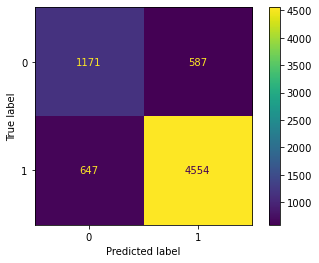

In [18]:
# Przeprowadź analizę jakości modelu. Krótko uzasadnij wybór metryk.

def printScores(model, X, Y):
    #BEGIN_SOLUTION
    y_pred = model.predict(X)
    ConfusionMatrixDisplay.from_estimator(model, X, Y)
    mcc = matthews_corrcoef(Y, y_pred)
    print(mcc)
    #END_SOLUTION

printScores(model, X_test, Y_test)

In [19]:
# Znajdź 10 najbardziej istotnych słów dla obu klas
#BEGIN_SOLUTION
feature_names = vectorizer.get_feature_names_out()
feature_names = np.array(feature_names)
n = 10
coeff = np.exp(model.feature_log_prob_)
imp_spam = np.argsort(coeff[1])[-n:][::-1]
imp_ham = np.argsort(coeff[0])[-n:][::-1]

print("Słowa, które z największą pewnością wskazują maszynie, że artykuł jest prawdziwy:")
print(feature_names[imp_spam])

print("Słowa, które z największą pewnością wskazują maszynie, że artykuł nie jest prawdziwy:")
print(feature_names[imp_ham])
#END_SOLUTION
pass

Słowa, które z największą pewnością wskazują maszynie, że artykuł jest prawdziwy:
['new' 'about' 'from' 'she' '2018' 'kardashian' 'his' 'season' 'how'
 'awards']
Słowa, które z największą pewnością wskazują maszynie, że artykuł nie jest prawdziwy:
['jennifer' 'kardashian' 'brad' 'jenner' 'pitt' 'justin' 'about' 'not'
 'angelina' 'jolie']
